# Importing Dependencies

In [1]:
import os
import numpy as np

import cv2
import matplotlib.pylab as plt

import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Importing Evaluation Metrices 

In [3]:
from tensorflow.keras.metrics import Precision, Recall, SpecificityAtSensitivity

pre = Precision()
rec = Recall()
spe = SpecificityAtSensitivity(0.5)

# Creating CNN Model

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 32)        0

In [5]:
logdir = 'LogDir'

try:
    os.mkdir(logdir)
except Exception as e:
    pass    

tfb_callback = tf.keras.callbacks.TensorBoard(logdir)

# Loading Dataset

In [6]:
train_dir = 'imgdata_v2/split_dataset/train/'
val_dir = 'imgdata_v2/split_dataset/val/'
test_dir = 'imgdata_v2/split_dataset/test/'

In [7]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=(256, 256))
val_dataset = tf.keras.utils.image_dataset_from_directory(val_dir, image_size=(256, 256))

Found 1456 files belonging to 2 classes.
Found 415 files belonging to 2 classes.


In [8]:
print(train_dataset.as_numpy_iterator().next()[0][0].shape)
print(train_dataset.as_numpy_iterator().next()[0][0].max())
print(train_dataset.as_numpy_iterator().next()[0][0].min())

(256, 256, 3)
255.0
0.0


In [9]:
train_data = train_dataset.map(lambda x, y: (x/255, y))
val_data = val_dataset.map(lambda x, y: (x/255, y))

In [10]:
print(train_data.as_numpy_iterator().next()[0][0].shape)
print(train_data.as_numpy_iterator().next()[0][0].max())
print(train_data.as_numpy_iterator().next()[0][0].min())

(256, 256, 3)
1.0
0.0


# Training Non-Augmented Model

In [11]:
model_fit = model.fit(train_data, 
                      epochs=30, 
                      shuffle=True, 
                      validation_data=val_data, 
                      callbacks=[tfb_callback])

Epoch 1/30
46/46 [==============================] - 16s 213ms/step - loss: 0.8567 - accuracy: 0.5625 - val_loss: 0.6789 - val_accuracy: 0.5205
Epoch 2/30
46/46 [==============================] - 9s 190ms/step - loss: 0.4658 - accuracy: 0.8139 - val_loss: 0.5401 - val_accuracy: 0.7711
Epoch 3/30
46/46 [==============================] - 9s 186ms/step - loss: 0.3791 - accuracy: 0.8475 - val_loss: 0.5216 - val_accuracy: 0.7711
Epoch 4/30
46/46 [==============================] - 9s 187ms/step - loss: 0.3467 - accuracy: 0.8681 - val_loss: 0.4978 - val_accuracy: 0.7831
Epoch 5/30
46/46 [==============================] - 9s 185ms/step - loss: 0.3411 - accuracy: 0.8668 - val_loss: 0.4009 - val_accuracy: 0.8482
Epoch 6/30
46/46 [==============================] - 9s 186ms/step - loss: 0.2991 - accuracy: 0.8729 - val_loss: 0.4023 - val_accuracy: 0.8602
Epoch 7/30
46/46 [==============================] - 9s 187ms/step - loss: 0.2614 - accuracy: 0.8894 - val_loss: 0.3455 - val_accuracy: 0.8747
Epoch

# Plotting Model Performance

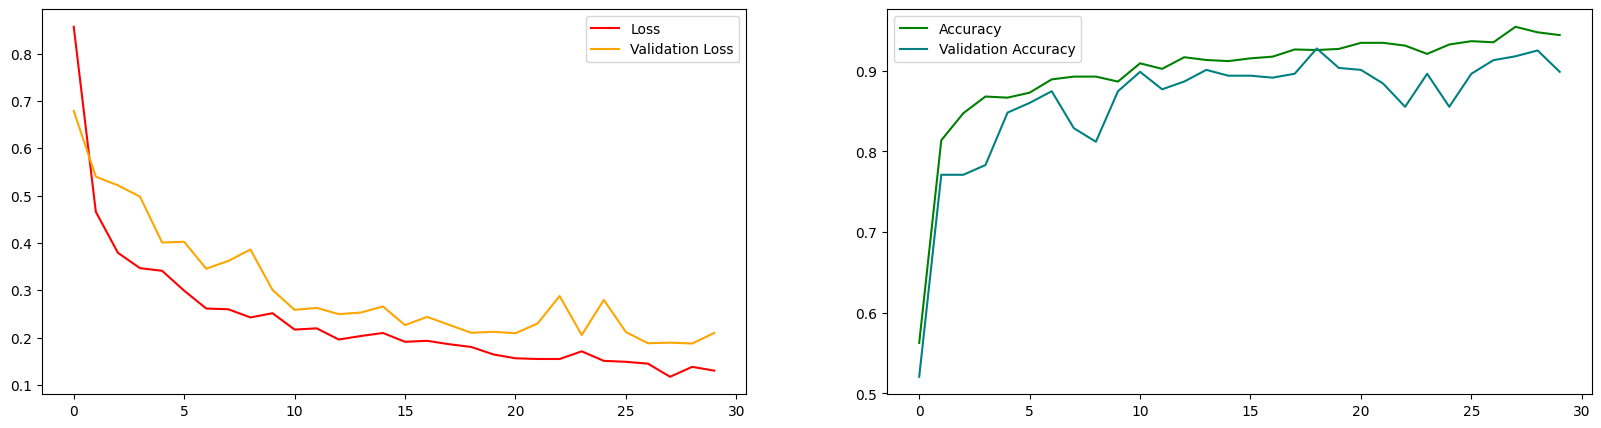

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))

axs[0].plot(model_fit.history['loss'], 
            color='red', 
            label='Loss')
axs[0].plot(model_fit.history['val_loss'], 
            color='orange', 
            label='Validation Loss')
axs[0].legend(loc='upper right')

axs[1].plot(model_fit.history['accuracy'], 
             color='green', 
             label='Accuracy')
axs[1].plot(model_fit.history['val_accuracy'], 
             color='teal', 
             label='Validation Accuracy')
axs[1].legend(loc='upper left')

# Evaluating Model Performance

In [13]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir, image_size=(256, 256))

Found 210 files belonging to 2 classes.


In [14]:
test_data = test_dataset.map(lambda x, y: (x/255, y))

In [15]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, SpecificityAtSensitivity

pre = Precision()
acc = BinaryAccuracy()
rec = Recall()
spe = SpecificityAtSensitivity(0.5)

In [16]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    pre.update_state(y, y_pred)
    rec.update_state(y, y_pred)
    acc.update_state(y, y_pred)
    spe.update_state(y, y_pred)

1/1 [==============================] - 1s 528ms/step


In [17]:
precision = pre.result().numpy()
recall = rec.result().numpy()
f1 = 2 * (precision*recall) / (precision+recall)

print('Accuracy\t:', acc.result().numpy())
print('Precision\t:', precision)
print('Recall\t\t:', recall)
print('Specificity\t:', spe.result().numpy())
print('F1\t\t:', f1)

Accuracy	: 0.89047617
Precision	: 0.84
Recall		: 0.9722222
Specificity	: 1.0
F1		: 0.9012874734689899


# ----------------------------------